In [1]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from keras.regularizers import l1_l2
from keras.models import Model, clone_model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Concatenate, Activation, Subtract, merge, Reshape, UpSampling2D
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras import backend as K
from keras import optimizers
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm_notebook
from os import listdir
from os.path import isfile, join
from keras.utils import to_categorical
from sklearn.metrics import precision_recall_fscore_support
import pickle
from pgmpy.readwrite import BIFReader
import tqdm
from pgmpy.inference import VariableElimination
%matplotlib inline

Using TensorFlow backend.


In [2]:
stickyPath = "../../dataset/unseen-dataset/TrainingSet/"
seenData = [f for f in listdir(stickyPath) if isfile(join(stickyPath, f))]
testData = [f for f in listdir("../../dataset/unseen-dataset/ValidationSet/") if isfile(join("../../dataset/unseen-dataset/ValidationSet/", f))]

In [3]:
trainData = seenData[0:int(len(seenData)*0.9)]
valData = seenData[int(len(seenData)*0.9):]

In [4]:
feature_data = pd.read_csv("../../dataset/15features.csv")

In [5]:
feature_data.head()

,imagename,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,staff_of_a,formation_n,staff_of_d,exit_stroke_d,word_formation,constancy
0,0968c_num1.png,2,2,2,1,2,2,3,2,1,2,2,3,2,2,1
1,0809c_num2.png,2,2,2,2,2,2,3,1,1,2,2,3,1,2,2
2,0237b_num6.png,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2
3,0069b_num2.png,2,2,2,1,2,2,1,1,1,1,1,1,1,1,1
4,0966c_num4.png,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2


In [6]:
cat_dict = {}
for idx,columns in enumerate(feature_data.columns):
    if columns != "imagename":
        cat_dict[idx]=len(np.unique(feature_data[columns]))
cat_dict

{1: 2,
 2: 3,
 3: 3,
 4: 3,
 5: 2,
 6: 2,
 7: 4,
 8: 2,
 9: 2,
 10: 4,
 11: 2,
 12: 3,
 13: 4,
 14: 2,
 15: 2}

In [7]:
train_features = feature_data[feature_data["imagename"].isin(trainData)]
for idx,columns in enumerate(train_features.columns):
    if columns != "imagename":
        train_features[str(columns)] = train_features[str(columns)] - 1
        train_features[str(columns)] = list(to_categorical(train_features[str(columns)],num_classes=cat_dict[idx]))

/home/ubuntu/anaconda3/envs/expKerasPgm/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/ubuntu/anaconda3/envs/expKerasPgm/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [8]:
val_features = feature_data[feature_data["imagename"].isin(valData)]
for idx,columns in enumerate(val_features.columns):
    if columns != "imagename":
        val_features[str(columns)] = val_features[str(columns)] - 1
        val_features[str(columns)] = list(to_categorical(val_features[str(columns)],num_classes=cat_dict[idx]))


/home/ubuntu/anaconda3/envs/expKerasPgm/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/ubuntu/anaconda3/envs/expKerasPgm/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [9]:
test_features = feature_data[feature_data["imagename"].isin(testData)]
test_features_normal = feature_data[feature_data["imagename"].isin(testData)]
for idx,columns in enumerate(test_features.columns):
    if columns != "imagename":
        test_features[str(columns)] = test_features[str(columns)] - 1
        test_features_normal[str(columns)] = test_features_normal[str(columns)] - 1
        test_features[str(columns)] = list(to_categorical(test_features[str(columns)],num_classes=cat_dict[idx]))

/home/ubuntu/anaconda3/envs/expKerasPgm/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/ubuntu/anaconda3/envs/expKerasPgm/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/anaconda3/envs/expKerasPgm/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [10]:
def datagen(batchSize,train_features,stickyPath):
    idx = 0
    hshift = (-64,64)
    vshift = (-64,64)
    while(True):
        subset = train_features.sample(n=batchSize).reset_index(drop=True)
        data = list(subset.imagename)
        returnInput=[]
        returnOutput=[]
        f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15 = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
        for image in data:
            skeleton = []
            left = cv2.imread(str(stickyPath+image),cv2.IMREAD_GRAYSCALE)
            #right = data.iloc[row,1]
            #right = cv2.imread(str("../dataset/seen-dataset/TrainingSet/"+right),cv2.IMREAD_GRAYSCALE)
            
            # Floating Point
            leftImage = left.astype('float32')
            leftImage /= 255
            leftImage = 1 - leftImage
            #rightImage = right.astype('float32')
            #rightImage /= 255
            
            temp=[leftImage]

            skeleton.append(temp)
            
            features = train_features[train_features.imagename == image].iloc[:,1:].values
            f1.append(np.array(features[0][0],dtype='int32').tolist())
            f2.append(np.array(features[0][1],dtype='int32').tolist())
            f3.append(np.array(features[0][2],dtype='int32').tolist())
            f4.append(np.array(features[0][3],dtype='int32').tolist())
            f5.append(np.array(features[0][4],dtype='int32').tolist())
            f6.append(np.array(features[0][5],dtype='int32').tolist())
            f7.append(np.array(features[0][6],dtype='int32').tolist())
            f8.append(np.array(features[0][7],dtype='int32').tolist())
            f9.append(np.array(features[0][8],dtype='int32').tolist())
            f10.append(np.array(features[0][9],dtype='int32').tolist())
            f11.append(np.array(features[0][10],dtype='int32').tolist())
            f12.append(np.array(features[0][11],dtype='int32').tolist())
            f13.append(np.array(features[0][12],dtype='int32').tolist())
            f14.append(np.array(features[0][13],dtype='int32').tolist())
            f15.append(np.array(features[0][14],dtype='int32').tolist())
            
            # Shifting
            randH = np.random.randint(hshift[0],hshift[1])
            randV = np.random.randint(vshift[0],vshift[1])
            
            leftImageShiftedH=np.roll(axis=0,a=leftImage,shift=randH)
            #rightImageShiftedH=np.roll(axis=0,a=rightImage,shift=randH)
            
            leftImageShiftedV=np.roll(axis=0,a=leftImage,shift=randV)
            #rightImageShiftedV=np.roll(axis=0,a=rightImage,shift=randV)
            
            temp = [leftImageShiftedV]
            skeleton.append(temp)
            f1.append(np.array(features[0][0],dtype='int32').tolist())
            f2.append(np.array(features[0][1],dtype='int32').tolist())
            f3.append(np.array(features[0][2],dtype='int32').tolist())
            f4.append(np.array(features[0][3],dtype='int32').tolist())
            f5.append(np.array(features[0][4],dtype='int32').tolist())
            f6.append(np.array(features[0][5],dtype='int32').tolist())
            f7.append(np.array(features[0][6],dtype='int32').tolist())
            f8.append(np.array(features[0][7],dtype='int32').tolist())
            f9.append(np.array(features[0][8],dtype='int32').tolist())
            f10.append(np.array(features[0][9],dtype='int32').tolist())
            f11.append(np.array(features[0][10],dtype='int32').tolist())
            f12.append(np.array(features[0][11],dtype='int32').tolist())
            f13.append(np.array(features[0][12],dtype='int32').tolist())
            f14.append(np.array(features[0][13],dtype='int32').tolist())
            f15.append(np.array(features[0][14],dtype='int32').tolist())
            
            
            temp = [leftImageShiftedH]
            skeleton.append(temp)
            
            f1.append(np.array(features[0][0],dtype='int32').tolist())
            f2.append(np.array(features[0][1],dtype='int32').tolist())
            f3.append(np.array(features[0][2],dtype='int32').tolist())
            f4.append(np.array(features[0][3],dtype='int32').tolist())
            f5.append(np.array(features[0][4],dtype='int32').tolist())
            f6.append(np.array(features[0][5],dtype='int32').tolist())
            f7.append(np.array(features[0][6],dtype='int32').tolist())
            f8.append(np.array(features[0][7],dtype='int32').tolist())
            f9.append(np.array(features[0][8],dtype='int32').tolist())
            f10.append(np.array(features[0][9],dtype='int32').tolist())
            f11.append(np.array(features[0][10],dtype='int32').tolist())
            f12.append(np.array(features[0][11],dtype='int32').tolist())
            f13.append(np.array(features[0][12],dtype='int32').tolist())
            f14.append(np.array(features[0][13],dtype='int32').tolist())
            f15.append(np.array(features[0][14],dtype='int32').tolist())
            
            returnInput.append(skeleton)
            

            
        returnInput = np.array(returnInput)
        returnInput = returnInput.reshape(batchSize*3,64,64)
        
        blank =[]
        
        blank.append(returnInput)
        
        returnInput = np.array(blank)
        
        returnInput = np.moveaxis(returnInput,0,3)
        
        outList = [f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15]

        for idx,item in enumerate(outList):
            outList[idx] = np.array(item)
        
        yield returnInput,outList
        
def testvalgen(batchSize,train_features,stickyPath):
    idx = 0
    hshift = (-64,64)
    vshift = (-64,64)
    while(True):
        subset = train_features.sample(frac=1).reset_index(drop=True)
        data = list(subset.imagename)
        returnInput=[]
        returnOutput=[]
        f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15 = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
        for image in data:
            skeleton = []
            left = cv2.imread(str(stickyPath+image),cv2.IMREAD_GRAYSCALE)
            #right = data.iloc[row,1]
            #right = cv2.imread(str("../dataset/seen-dataset/TrainingSet/"+right),cv2.IMREAD_GRAYSCALE)
            
            # Floating Point
            leftImage = left.astype('float32')
            leftImage /= 255
            leftImage = 1 - leftImage
            #rightImage = right.astype('float32')
            #rightImage /= 255
            
            temp=[leftImage]

            skeleton.append(temp)
            
            features = train_features[train_features.imagename == image].iloc[:,1:].values
            f1.append(np.array(features[0][0],dtype='int32').tolist())
            f2.append(np.array(features[0][1],dtype='int32').tolist())
            f3.append(np.array(features[0][2],dtype='int32').tolist())
            f4.append(np.array(features[0][3],dtype='int32').tolist())
            f5.append(np.array(features[0][4],dtype='int32').tolist())
            f6.append(np.array(features[0][5],dtype='int32').tolist())
            f7.append(np.array(features[0][6],dtype='int32').tolist())
            f8.append(np.array(features[0][7],dtype='int32').tolist())
            f9.append(np.array(features[0][8],dtype='int32').tolist())
            f10.append(np.array(features[0][9],dtype='int32').tolist())
            f11.append(np.array(features[0][10],dtype='int32').tolist())
            f12.append(np.array(features[0][11],dtype='int32').tolist())
            f13.append(np.array(features[0][12],dtype='int32').tolist())
            f14.append(np.array(features[0][13],dtype='int32').tolist())
            f15.append(np.array(features[0][14],dtype='int32').tolist())
            
            returnInput.append(skeleton)
            

            
        returnInput = np.array(returnInput)
        returnInput = returnInput.reshape(len(train_features)*1,64,64)
        
        blank =[]
        
        blank.append(returnInput)
        
        returnInput = np.array(blank)
        
        returnInput = np.moveaxis(returnInput,0,3)
        
        outList = [f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15]

        for idx,item in enumerate(outList):
            outList[idx] = np.array(item)
        
        yield returnInput,outList
    

In [11]:
input_img = Input(shape=(64, 64, 1))  # adapt this if using `channels_first` image data format
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
encoded = Flatten()(x)
encoded = Dense(8*8*8, activation='relu', name='latent')(encoded)
# model = Model(input_img,encoded)
# print(model.summary())
# at this point the representation is (4, 4, 8) i.e. 128-dimensional
r = Reshape(target_shape=(8,8,8))(encoded)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(r)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
#x = BatchNormalization()(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='output')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='RMSprop', loss='binary_crossentropy')

#display(SVG(model_to_dot(autoencoder, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg')))


Instructions for updating:
Colocations handled automatically by placer.


In [12]:
autoencoder.load_weights("../weights/simple_ae_maxpool_unseen_weights_v1.h5")

In [13]:
encoder = Model(inputs=autoencoder.inputs,outputs=autoencoder.get_layer('latent').output)

In [14]:
#display(SVG(model_to_dot(encoder, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg')))

### Frezzing weights

In [15]:
for layer in encoder.layers:
    layer.trainable = True

In [16]:
_input = encoder.output
# Feature1
layerf1 = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
layerf1 = BatchNormalization()(layerf1)

# Feature2
layerf2 = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
#layerf2 = BatchNormalization()(layerf2)
#layerf2 = Dense(64,activation='relu',kernel_initializer="glorot_normal")(layerf2)
layerf2 = BatchNormalization()(layerf2)

# Feature3
layerf3 = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
layerf3 = BatchNormalization()(layerf3)

# Feature4
layerf4 = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
#layerf4 = BatchNormalization()(layerf4)
#layerf4 = Dense(64,activation='relu',kernel_initializer="glorot_normal")(layerf4)
layerf4 = BatchNormalization()(layerf4)

# Feature5
layerf5_c = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
#layerf5_c = BatchNormalization()(layerf5_c)
#layerf5_c = Dense(64,activation='relu',kernel_initializer="glorot_normal")(layerf5_c)
layerf5 = BatchNormalization()(layerf5_c)

# Feature6
layerf6 = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
#layerf6 = BatchNormalization()(layerf6)
#layerf6 = Dense(64,activation='relu',kernel_initializer="glorot_normal")(layerf6)
#layerf6 = Concatenate()([layerf6,layerf5_c])
layerf6 = BatchNormalization()(layerf6)

# Feature7
layerf7_c = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
#layerf7_c = BatchNormalization()(layerf7_c)
#layerf7_c = Dense(64,activation='relu',kernel_initializer="glorot_normal")(layerf7_c)
layerf7 = BatchNormalization()(layerf7_c)

# Feature8
layerf8 = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
#layerf8 = BatchNormalization()(layerf8)
#layerf8 = Dense(64,activation='relu',kernel_initializer="glorot_normal")(layerf8)
#layerf8 = Concatenate()([layerf8,layerf7_c])
layerf8 = BatchNormalization()(layerf8)

# Feature9
layerf9_c = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
layerf9 = BatchNormalization()(layerf9_c)

# Feature10
layerf10_c = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
#layerf10_c = BatchNormalization()(layerf10_c)
#layerf10_c = Dense(64,activation='relu',kernel_initializer="glorot_normal")(layerf10_c)
layerf10 = BatchNormalization()(layerf10_c)

# Feature11
layerf11 = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
#layerf11 = BatchNormalization()(layerf11)
#layerf11 = Dense(64,activation='relu',kernel_initializer="glorot_normal")(layerf11)
layerf11 = BatchNormalization()(layerf11)

# Feature12
layerf12 = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
#layerf12 = BatchNormalization()(layerf12)
#layerf12 = Dense(64,activation='relu',kernel_initializer="glorot_normal")(layerf12)
#layerf12 = Concatenate()([layerf12,layerf10_c])
layerf12 = BatchNormalization()(layerf12)

# Feature13
layerf13 = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
#layerf13 = Concatenate()([layerf13,layerf9_c])
layerf13 = BatchNormalization()(layerf13)

# Feature14
layerf14 = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
layerf14 = BatchNormalization()(layerf14)

# Feature15
layerf15 = Dense(128,activation='relu',kernel_initializer="glorot_normal")(_input)
#layerf15 = BatchNormalization()(layerf15)
#layerf15 = Dense(64,activation='relu',kernel_initializer="glorot_normal")(layerf15)
layerf15 = BatchNormalization()(layerf15)


layerOut1 = Dense(2,activation='softmax',name="pen_pressure",kernel_initializer="glorot_normal")(layerf1)
layerOut2 = Dense(3,activation='softmax',name="letter_spacing",kernel_initializer="glorot_normal")(layerf2)
layerOut3 = Dense(3,activation='softmax',name="size",kernel_initializer="glorot_normal")(layerf3)
layerOut4 = Dense(3,activation='softmax',name="dimension",kernel_initializer="glorot_normal")(layerf4)
layerOut5 = Dense(2,activation='softmax',name="is_lowercase",kernel_initializer="glorot_normal")(layerf5)
layerOut6 = Dense(2,activation='softmax',name="is_continuous",kernel_initializer="glorot_normal")(layerf6)
layerOut7 = Dense(4,activation='softmax',name="slantness",kernel_initializer="glorot_normal")(layerf7)
layerOut8 = Dense(2,activation='softmax',name="tilt",kernel_initializer="glorot_normal")(layerf8)
layerOut9 = Dense(2,activation='softmax',name="entry_stroke_a",kernel_initializer="glorot_normal")(layerf9)
layerOut10 = Dense(4,activation='softmax',name="staff_of_a",kernel_initializer="glorot_normal")(layerf10)
layerOut11 = Dense(2,activation='softmax',name="formation_n",kernel_initializer="glorot_normal")(layerf11)
layerOut12 = Dense(3,activation='softmax',name="staff_of_d",kernel_initializer="glorot_normal")(layerf12)
layerOut13 = Dense(4,activation='softmax',name="exit_stroke_d",kernel_initializer="glorot_normal")(layerf13)
layerOut14 = Dense(2,activation='softmax',name="word_formation",kernel_initializer="glorot_normal")(layerf14)
layerOut15 = Dense(2,activation='softmax',name="constancy",kernel_initializer="glorot_normal")(layerf15)

In [17]:
xai_NN = Model(encoder.input,[layerOut1,layerOut2,layerOut3,layerOut4,layerOut5,
                                 layerOut6,layerOut7,layerOut8,layerOut9,layerOut10,
                                layerOut11,layerOut12,layerOut13,layerOut14,layerOut15])

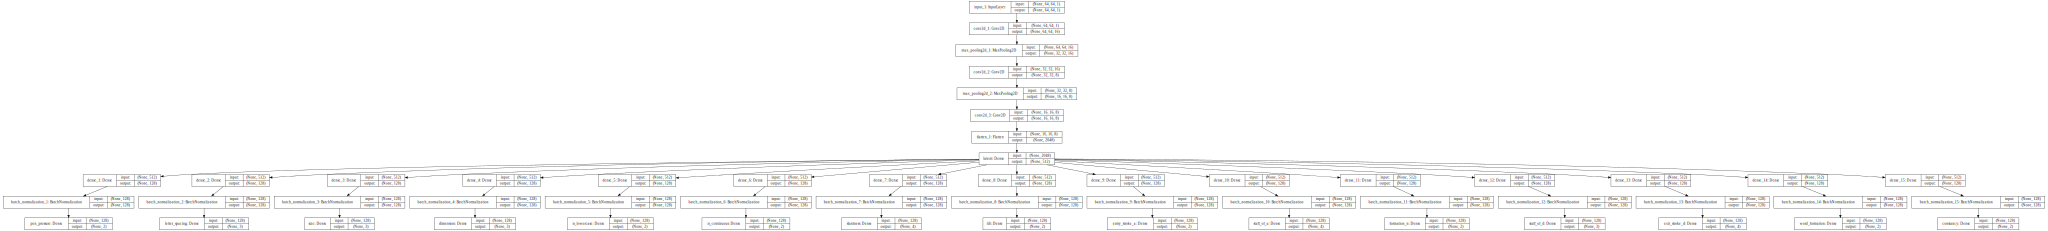

In [18]:
display(SVG(model_to_dot(xai_NN, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg')))

In [19]:
lossesDict = {}
for idx,column in enumerate(train_features.columns):
    if idx  != 0:
        lossesDict[columns] = "categorical_crossentropy"

rmsProp = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
xai_NN.compile(optimizer=rmsProp, loss='categorical_crossentropy',metrics=['categorical_accuracy'])

In [20]:
batchSize=25
trainGenObj = datagen(batchSize,train_features,stickyPath)
valGenObj = testvalgen(len(val_features),val_features,stickyPath)
testGenObj = testvalgen(len(test_features),test_features,"../../dataset/unseen-dataset/ValidationSet/")

In [22]:
LOG_DIR = '../log/xai/seen'
#runIter = 0

In [24]:
mc = ModelCheckpoint(filepath='../weights/xai_mulltitask_unseen_weights_v1.h5', 
                     monitor='val_loss',period=1,save_best_only=True,
                     save_weights_only=True,mode='auto',verbose=1)
es = EarlyStopping(patience=15, monitor='val_loss', min_delta=0.0005, mode='auto')
tbCallBack = TensorBoard(log_dir=str(LOG_DIR+"/run"+str(runIter)), histogram_freq=0,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batchSize,
                         write_images=True)
runIter+=1

In [25]:
# ((len(trainData)//batchSize)*3)

In [27]:
'''

xai_NN.fit_generator(
    trainGenObj,
    epochs=30,
    verbose=2,
    validation_data=valGenObj,
    validation_steps=1,
    steps_per_epoch=((len(trainData)//batchSize)*3),
    callbacks=[es,tbCallBack,mc]
)

'''

'\n\nxai_NN.fit_generator(\n    trainGenObj,\n    epochs=30,\n    verbose=2,\n    validation_data=valGenObj,\n    validation_steps=1,\n    steps_per_epoch=((len(trainData)//batchSize)*3),\n    callbacks=[es,tbCallBack,mc]\n)\n\n'

In [28]:
xai_NN.load_weights("../weights/xai_mulltitask_unseen_weights_v1.h5")

In [29]:
xai_NN.evaluate_generator(testGenObj,steps=1)

[8.826377868652344,
 0.2860855758190155,
 0.9339743256568909,
 0.5328909754753113,
 0.6271829009056091,
 0.08539844304323196,
 0.4030196964740753,
 0.884725034236908,
 0.45977091789245605,
 0.07908597588539124,
 0.9705101251602173,
 0.49419766664505005,
 0.7727504968643188,
 1.0662893056869507,
 0.5945141911506653,
 0.6359823942184448,
 0.8742724061012268,
 0.5552968382835388,
 0.753201425075531,
 0.7124563455581665,
 0.9848661422729492,
 0.8242142200469971,
 0.6088474988937378,
 0.8440046310424805,
 0.9615832567214966,
 0.6426076889038086,
 0.7776484489440918,
 0.6414435505867004,
 0.530849814414978,
 0.690337598323822,
 0.6728754639625549]

In [30]:
output = xai_NN.predict_generator(testGenObj,steps=1)

pred = [[] for _ in range(15)]
for idx in range(15):
    pred[idx].append(np.argmax(output[idx],axis=1))

pred = np.array(pred)
pred = pred.T

pred = pred.reshape((len(pred),15))
predDF = pd.DataFrame(data = pred,columns=test_features.columns[1:])


In [31]:
predDF.head()

,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,staff_of_a,formation_n,staff_of_d,exit_stroke_d,word_formation,constancy
0,1,1,1,0,1,1,1,0,0,1,1,2,3,0,1
1,1,1,0,0,1,1,2,0,0,1,1,2,1,0,0
2,1,1,0,0,1,1,2,1,0,1,1,2,3,0,0
3,1,1,1,1,1,1,1,1,0,1,1,2,1,0,1
4,1,2,1,0,1,0,0,0,0,1,1,1,3,0,1


In [32]:
observed = test_features_normal.iloc[:,1:].values.tolist()
observed = np.array(observed)
for idx in range(15):
    print("Feature " + str(idx)+str(precision_recall_fscore_support(pred[:,idx],observed[:,idx],average='weighted')))

Feature 0(0.7474244624536078, 0.6740395809080326, 0.7057421554152625, None)
Feature 1(0.5574749285116848, 0.4318975552968568, 0.4846784226304366, None)
Feature 2(0.4386004955685198, 0.38882421420256114, 0.4076060004323096, None)
Feature 3(0.4509457410585426, 0.409778812572759, 0.4210077995787353, None)
Feature 4(1.0, 0.9848661233993015, 0.9923753665689149, None)
Feature 5(0.6672758885059058, 0.6542491268917345, 0.6604480847475812, None)
Feature 6(0.35963613956014073, 0.34342258440046564, 0.35127564989057225, None)
Feature 7(0.7630466607043823, 0.7252619324796274, 0.7429697781348984, None)
Feature 8(0.9904999022798535, 0.9522700814901047, 0.9710088487466184, None)
Feature 9(0.9677813035869895, 0.6344586728754366, 0.7649333447299403, None)
Feature 10(0.8870403636947534, 0.7240977881257276, 0.7947111070301547, None)
Feature 11(0.48544162178970296, 0.45052386495925495, 0.4605592426561219, None)
Feature 12(0.3953444163435559, 0.3445867287543655, 0.36472907666452803, None)
Feature 13(0.59235

/home/ubuntu/anaconda3/envs/expKerasPgm/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Stitching both DL and PGM

In [33]:
def deterministic_sigmoid_node(biasNodeAccumulatorNode):
    return 1/(1+np.exp(biasNodeAccumulatorNode*-1))

def deterministic_verification_node(nodeOutputs,weights,b):
    weightFeaturesAccumulatorNode = np.dot(weights,nodeOutputs)
    biasNodeAccumulatorNode = b[0]+weightFeaturesAccumulatorNode[0]
    return deterministic_sigmoid_node(biasNodeAccumulatorNode)

In [34]:
with open ('../weights/sigmoid_cpd_weight_entropy_unseen', 'rb') as fp:
    weights = pickle.load(fp)

In [35]:
with open ('../weights/sigmoid_cpd_bias_entropy_unseen', 'rb') as fp:
    b = pickle.load(fp)

In [36]:
pgmModel = BIFReader("../weights/pgmModel.bif")

In [37]:
pgmModel = pgmModel.get_model()

In [38]:
pgmModel.check_model()

True

In [39]:
var = {'is_pen_pressure_sim',
       'is_slantness_sim',
       'is_tilt_sim',
       'is_staff_of_a_sim',
       'is_staff_of_d_sim',
       'entry_stroke_a_sim',
       'is_exit_stroke_d_sim',
      'is_lowercase_sim',
      'is_continuous_sim',
      'dimension_sim',
      'letter_spacing_sim',
       'size_sim',
       'constancy_sim',
       'word_formation_sim',
       'formation_n_sim'
      }


In [40]:
evidence_labels = feature_data.columns[1:]+str(1)

evidence_labels = evidence_labels.append(feature_data.columns[1:]+str(2))

In [41]:
mle = VariableElimination(pgmModel)

In [42]:
feature_data = pd.read_csv("../../dataset/15features.csv")

In [43]:
test_data_pairs = pd.read_csv("../../dataset/unseen-dataset/dataset_seen_validation_siamese.csv")
test_data_pairs.head()

,Unnamed: 0,left,right,label
0,0,1469b_num3.png,1469b_num2.png,1
1,1,1469b_num3.png,1469c_num2.png,1
2,2,1469b_num3.png,1469a_num1.png,1
3,3,1469b_num3.png,1469a_num3.png,1
4,4,1469b_num3.png,1469c_num1.png,1


In [45]:
def xai_inference(test_data_pairs,feature_data,xai_NN,mle,var,evidence_labels,vis=False):
    pred_label = []
    obsLabel = []
    for idx in tqdm_notebook(range(len(test_data_pairs))):
        imageLeft = cv2.imread(str("../../dataset/unseen-dataset/ValidationSet/"+test_data_pairs.iloc[idx].left),cv2.IMREAD_GRAYSCALE)
        imageRight = cv2.imread(str("../../dataset/unseen-dataset/ValidationSet/"+test_data_pairs.iloc[idx].right),cv2.IMREAD_GRAYSCALE)
        obsLabel.append(test_data_pairs.iloc[idx].label)
        
        leftImage = imageLeft.astype('float32')
        leftImage /= 255
        leftImage = 1 - leftImage
        rightImage = imageRight.astype('float32')
        rightImage /= 255
        rightImage = 1 - rightImage
        
        left = leftImage.reshape((1,64,64,1))
        right = rightImage.reshape((1,64,64,1))
        
        pred_one_hot_left = xai_NN.predict(left)
        pred_one_hot_right = xai_NN.predict(right)
        
        pred_left = [[] for _ in range(15)]
        pred_right = [[] for _ in range(15)]
        for idx in range(15):
            pred_left[idx].append(np.argmax(pred_one_hot_left[idx],axis=1))
            pred_right[idx].append(np.argmax(pred_one_hot_right[idx],axis=1))
            
        pred_left = np.array(pred_left)
        pred_left = pred_left.reshape(1,15)
        pred_right = np.array(pred_right)
        pred_right = pred_right.reshape(1,15)
        
        pred_left = list(pred_left[0])
        pred_right = list(pred_right[0])
        
        pred_left.extend(pred_right)
        concat = pred_left
        
        inf = mle.query(variables=var,evidence=dict(zip(evidence_labels,concat)))
        
        holdInf = []
        for simfeature in var:
            holdInf.append(np.argmax(inf[simfeature].values))
            
        pred = deterministic_verification_node(holdInf,weights,b)
        pred_label.append(np.round(pred))
        
        if(vis):
            
            f, axarr = plt.subplots(1,2)

            axarr[0].imshow(imageLeft)
            axarr[1].imshow(imageRight)

            plt.rcdefaults()
            
            performance = np.round([inf['is_pen_pressure_sim'].values[1],
                                    inf['is_slantness_sim'].values[1],
                                    inf['is_tilt_sim'].values[1],
                                    inf['is_staff_of_a_sim'].values[1],
                                    inf['is_staff_of_d_sim'].values[1],
                                    inf['entry_stroke_a_sim'].values[1],
                                    inf['is_exit_stroke_d_sim'].values[1],
                                    inf['is_lowercase_sim'].values[1],
                                    inf['is_continuous_sim'].values[1],
                                    inf['dimension_sim'].values[1],
                                    inf['letter_spacing_sim'].values[1],
                                    inf['size_sim'].values[1],
                                    inf['constancy_sim'].values[1],
                                    inf['word_formation_sim'].values[1],
                                    inf['formation_n_sim'].values[1]],2)
            df_feat_sim_score = pd.DataFrame()
            df_feat_sim_score['features']=list(reversed(feature_data.keys()[1:]))
            df_feat_sim_score['feature similarity score']=list(reversed(performance))
            display(df_feat_sim_score)
            ax = df_feat_sim_score.plot.barh(width=0.85
                                             , rot=0
                                             , x='features'
                                             , color='lightblue'
                                             , fontsize=14
                                             , figsize=(5,8)
                                             , grid=True)
            df_feat_sim_score['feature similarity score'].mean()

            ax.legend(bbox_to_anchor=(0.75,-0.05)
                      , fontsize=14)
            ax.grid(color='#bebebe'
                    , linestyle='-.'
                    , linewidth=0.5)
            plt.ylabel('features',fontsize=14)
            counter=-1
            for p in ax.patches:
                counter+=1
                ax.annotate(str(p.get_width()), (0.25, counter*0.99))
            break
               
    return obsLabel,pred_label

In [46]:
for idx,columns in enumerate(feature_data.columns):
    if columns != "imagename":
        feature_data[str(columns)] = feature_data[str(columns)] - 1

In [47]:
y_obs,y_pred = xai_inference(test_data_pairs,feature_data,xai_NN,mle,var,evidence_labels)

/home/ubuntu/anaconda3/envs/expKerasPgm/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:586: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  phi.values = phi.values[slice_]
/home/ubuntu/anaconda3/envs/expKerasPgm/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:598: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  phi1.values = phi1.values[slice_]


In [48]:
acc =0
for idx in range(len(y_obs)):
    if y_obs[idx] == y_pred[idx]:
        acc +=1

In [49]:
acc/len(y_pred)

0.5

In [50]:
test_data_pairs = test_data_pairs.sample(frac=1)

,features,feature similarity score
0,constancy,0.45
1,word_formation,0.10
2,exit_stroke_d,0.20
3,staff_of_d,0.34
4,formation_n,0.90
5,staff_of_a,0.20
6,entry_stroke_a,0.82
7,tilt,0.90
8,slantness,0.40
9,is_continuous,0.90


([0], [1.0])

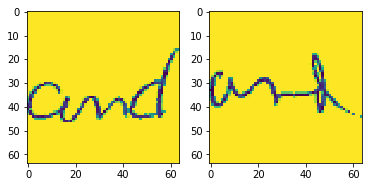

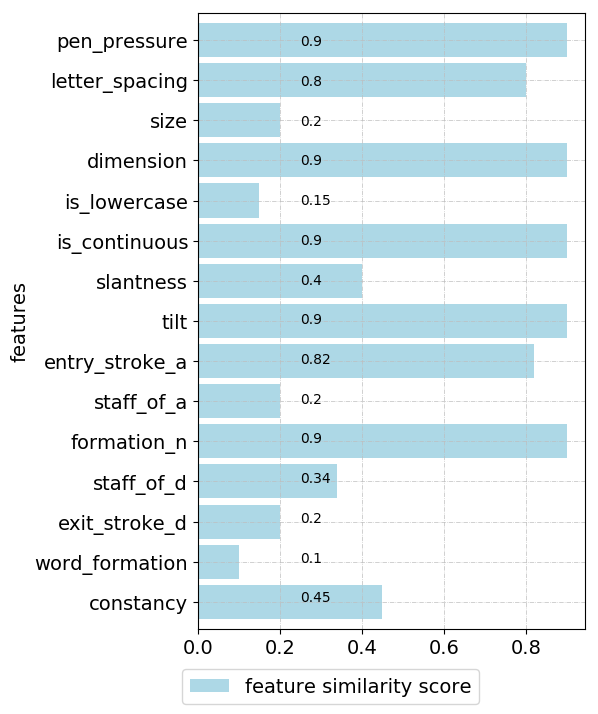

In [51]:
xai_inference(test_data_pairs.iloc[5:6,],feature_data,xai_NN,mle,var,evidence_labels,vis=True)